<h1 style="text-align:center">Deep Learning   </h1>
<h1 style="text-align:center"> Lab Session 3 - 1.5 Hours </h1>
<h1 style="text-align:center"> Sentiment Analysis with Recurrent Neural Networks</h1>

___

**Martin Guyard**

___

The aim of this session is to practice with VanillaRNN and Gated Recurrent Units (GRU). Each group should fill and run appropriate notebook cells. 

Follow instructions step by step until the end and submit your complete notebook as an archive (tar -cf groupXnotebook.tar DL_lab3/).

Do not forget to run all your cells before generating your final report and do not forget to include the names of all participants in the group. The lab session should be completed by June 12th 2019 (23:59:59 CET).

# Section 1: Sentiment Analysis with a Vanilla RNN

In this part, you will have no code to write. However you should spend some minutes on it, to understand well how the Vanilla RNN is implemented: you will implement a GRU in a similar way in Section 2.

You will work on a corpus of 3,000 user comments taken from IMDb (1,000), Amazon (1,000) and Yelp (1,000). These comments are split into two categories: positive comments (denoted by "1") and negative comments (denoted by "0"). For each website, 500 comments are positive and 500 comments are negative. This corpus has been created for the paper <i>From Group to Individual Labels using Deep Features</i> by Kotzias <i>et al</i>.

In this lab, we split this dataset into a training set of 2,520 comments (420 positive comments and 420 negative comments from each website), a validation set of 240 comments (40 positive comments and 40 negative comments from each website) and a test set of 240 comments (40 positive comments and 40 negative comments from each website).

Your goal will be to classify automatically these sentences by training a Vanilla RNN and then a GRU. Please note that we use the word2vec method to convert words into vectors: these vectors are designed so that they reflect the semantic and the syntactic functions of words. You can read more about word2vec in the paper <i>Distributed representations of words and phrases and their compositionality</i> by Mikolov <i>et al.</i>

First of all, please run the following cell.

In [1]:
# Imports
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
import utils

# Parameters
epsilon = 1e-10
max_l = 32 # Max length of sentences

train, val, test, word2vec = utils.load_data()
data = utils.Dataset(train, val, test, word2vec)

Instructions for updating:
non-resource variables are not supported in the long term


In the following cell, we define a VanillaRNN class. Please read its code carefully before running the cell because you will need to implement a similar class for the GRU.

If our sentence is represented by the sequence $(x_1, ..., x_L)$, the hidden states $h_t$ of the Vanilla RNN are defined as

<div align="center">$h_0 = 0$</div>
<div align="center">$h_{t+1} = f(W_h h_t + W_x x_{t+1} + b)$</div>

where $W_h$, $W_x$ and $b$ are trainable parameters and $f$ is an activation fucntion.

In [2]:
class VanillaRNN:

    def __init__(self, input_size, hidden_states, activation=None, name=None):
        self._hidden_states = hidden_states
        self._input_size = input_size
        self._activation = activation or tf.tanh
        self._name = (name or "vanilla_rnn") + "/"
        self._candidate_kernel = tf.get_variable(self._name + "candidate/weights",
                                                   shape=[input_size + self._hidden_states, self._hidden_states])
        self._candidate_bias = tf.get_variable(self._name + "candidate/bias", shape=[self._hidden_states])

    def state_size(self):
        return self._hidden_states

    def zero_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return tf.zeros([batch_size, self.state_size()], dtype=tf.float32)

    def __call__(self, inputs, state):

        candidate = tf.matmul(tf.concat([inputs, state], 1), self._candidate_kernel)
        candidate = tf.nn.bias_add(candidate, self._candidate_bias)
        new_h = self._activation(candidate)
        return new_h

<b>Parameters</b>
* Learning rate: 0.001
* Training epochs: 30
* Batch size: 128
* Hidden states: 50

In [3]:
# Parameters
learning_rate = 0.001
training_epochs = 30
batch_size = 128
hidden_states = 50

Then we define our model. Please read the code of the process_sequence() function to understand the utility of the MaskData placeholder. If $h_L$ is the last hidden state of the Vanilla RNN, then we define our final prediction $p$ as

<div align="center">$p = \sigma (W_{pred} h_L + b_{pred})$</div>

where $W_{pred}$ and $b_{pred}$ are trainable parameters and $\sigma$ denotes the sigmoid function.

In [4]:
tf.reset_default_graph()
tf.set_random_seed(123)
model_path = "models/vanilla.ckpt"
# tf Graph Input:  sentiment analysis data
# Sentences are padded with zero vectors
x = tf.placeholder(tf.float32, [None, max_l, 300], name='InputData')
# masks: necessary as we have different sentence lengths
m = tf.placeholder(tf.float32, [None, max_l, 1], name='MaskData')
# positive (1) or negative (0) labels
y = tf.placeholder(tf.float32, [None, 1], name='LabelData')

# we define our VanillaRNN cell
vanilla = VanillaRNN(300, hidden_states)

# we retrieve its last output
vanilla_output = utils.process_sequence(vanilla, x, m)

W = tf.Variable(tf.zeros([hidden_states, 1]), name='Weights')
b = tf.Variable(tf.zeros([1]), name='Bias')
# we make the final prediction
pred = tf.nn.sigmoid(tf.matmul(vanilla_output, W) + b)

<b>Question 0</b> - Why do we need a MaskData placeholder?

___
max_l=32 is the max length of sentences fed in the RNN. As sentences have different lengths we need a mask placeholder before feeding the sequence to the RNN. 

RNN need fixed size inputs to work. Therefore, what we do is to create a mask per sample initialised with 0 with a length equal to the longest sequence in the dataset. Then we fill the mask with 1s to all the position where the sample has values in.

<br>

**For instance:**

Let's say that that the longest sequence in the dataset it 5 (in our current dataset it is 32 though).

mask = [0., 0., 0., 0., 0.,]

And we have a sample:

s = [2, 3, 4]

Therefore we get the following mask for the sample:

mask_s = [1, 1, 1, 0, 0]

Then under the hood the RNN is going to replace the 1s with the values of s:

s_hood = [2, 3, 4, 0, 0]

And that is it! It is fixed sized and can be handled by the RNN. This is why we need MaskData placeholder!


**source:
https://www.quora.com/What-is-masking-in-a-recurrent-neural-network-RNN**
___

Eventually, we train our model using a cross-entropy loss and the Adam optimizer. At each epoch we check the validation accuracy, and save the model if that accuracy increased. At the end, we load the best model on validation, and print its accuracy on the test set.

We test our model using a $\tanh$ activation function.

In [5]:
with tf.name_scope('Loss'):
    # Minimize error using cross entropy
    # We use tf.clip_by_value to avoid having too low numbers in the log function
    cost = tf.reduce_mean(-y*tf.log(tf.clip_by_value(pred, epsilon, 1.0)) - (1.-y)*tf.log(tf.clip_by_value((1.-pred), epsilon, 1.0)))

with tf.name_scope('Adam'):
    # Gradient Descent
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
with tf.name_scope('Accuracy'):
    # Accuracy
    pred_tmp = tf.stack([pred, 1.-pred])
    y_tmp = tf.stack([y, 1.-y])
    acc = tf.equal(tf.argmax(pred_tmp, 0), tf.argmax(y_tmp, 0))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    print("Training started")
    best_val_acc = 0.
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(train)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ms, batch_ys = data.next_batch(batch_size)
            # Run optimization op (backprop), cost op (to get loss value)
            # and summary nodes
            _, c = sess.run([optimizer, cost],
                                     feed_dict={x: batch_xs, y: batch_ys, m: batch_ms})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        val_xs, val_ms, val_ys = data.val_batch()
        val_acc = acc.eval({x: val_xs, m: val_ms, y: val_ys})
        print("Accuracy on validation:", val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = saver.save(sess, model_path)
            print("        Model saved in file: %s" % save_path)
        print("Epoch: ", '%02d' % (epoch+1), "  =====> Loss=", "{:.9f}".format(avg_cost))

    # Test model
    # Calculate accuracy
    saver.restore(sess, model_path)
    test_xs, test_ms, test_ys = data.test_batch()
    print("Accuracy:", acc.eval({x: test_xs, m: test_ms, y: test_ys}))

Training started
Accuracy on validation: 0.5
        Model saved in file: models/vanilla.ckpt
Epoch:  01   =====> Loss= 0.694689268
Accuracy on validation: 0.6666667
        Model saved in file: models/vanilla.ckpt
Epoch:  02   =====> Loss= 0.690510916
Accuracy on validation: 0.7416667
        Model saved in file: models/vanilla.ckpt
Epoch:  03   =====> Loss= 0.662441821
Accuracy on validation: 0.69166666
Epoch:  04   =====> Loss= 0.582807362
Accuracy on validation: 0.77916664
        Model saved in file: models/vanilla.ckpt
Epoch:  05   =====> Loss= 0.528982081
Accuracy on validation: 0.79583335
        Model saved in file: models/vanilla.ckpt
Epoch:  06   =====> Loss= 0.471214083
Accuracy on validation: 0.80833334
        Model saved in file: models/vanilla.ckpt
Epoch:  07   =====> Loss= 0.430987816
Accuracy on validation: 0.8125
        Model saved in file: models/vanilla.ckpt
Epoch:  08   =====> Loss= 0.417951829
Accuracy on validation: 0.8208333
        Model saved in file: models

Did you understand everything? If so, you can move towards Section 2.

# Section 2: Your turn!

<b>Question 1</b> - Recall the formulas defining the hidden states of a GRU.

<img src=" 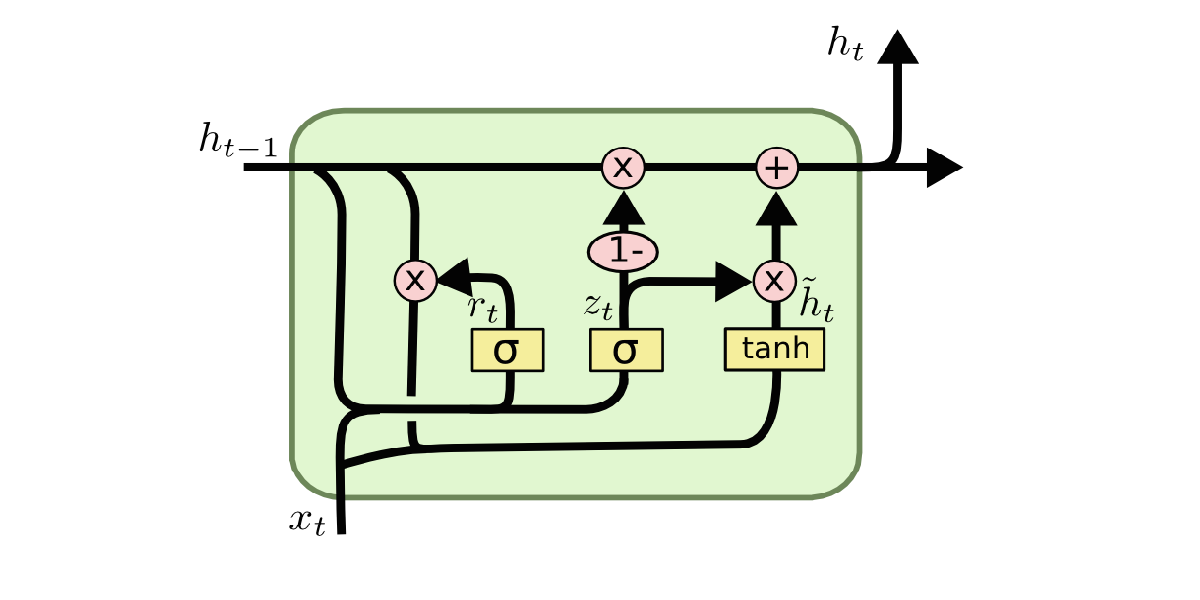" />



- Remember Gate: 
  - $r_t=sigmoid\left(W_r\cdot[h_{t-1}, x_t]\right)$
- Input Gate:
  - $\tilde{h_t}=tanh\left(W\cdot[r_t h_{t-1},x_t]\right)$ combine addition and forget gate
- Update Gate: 
  - $z_t = sigmoid\left(W_z\cdot [h_{t-1},x_t]\right)$
  - $h_{t} = (1-z_t)h_{t-1} + z_t \tilde{h_t}$

$tanh$ is the activation function, $sigmoid$ functions act as a switch (they need to be differentiable).

<b>Question 2</b> - Define a GRU similar to the Vanilla RNN that we defined in Section 1.

In [10]:
class GRU:

    def __init__(self, input_size, hidden_states, activation=None, name=None):
        self._hidden_states = hidden_states
        self._input_size = input_size
        self._activation = activation or tf.tanh
        self._name = (name or "gru") + "/"
        ############ CODE NEEDED ############
        # Define trainable parameters here  #
        #####################################
        
        # Remember
        self._remember_weights = tf.get_variable(self._name+"remember/weights",
            shape=[input_size+self._hidden_states, self._hidden_states])
        self._remember_bias = tf.get_variable(self._name+"remember/bias", shape=[self._hidden_states])
        
        # Input
        self._input_weights = tf.get_variable(self._name+"input/weights",
            shape=[input_size+self._hidden_states, self._hidden_states])
        self._input_bias = tf.get_variable(self._name+"input/bias", shape=[self._hidden_states])
        
        # Update
        self._update_weights = tf.get_variable(self._name+"update/weights",
            shape=[input_size+self._hidden_states, self._hidden_states])
        self._update_bias = tf.get_variable(self._name+"update/bias", shape=[self._hidden_states])

    def state_size(self):
        return self._hidden_states

    def output_size(self):
        return self._hidden_states

    def zero_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return tf.zeros([batch_size, self.state_size()], dtype=tf.float32)

    def __call__(self, inputs, state):
        ############ CODE NEEDED ############
        #  Write GRU operations according   #
        #   to your answer at question 1    #
        #####################################
        
        zt = tf.sigmoid(tf.matmul(tf.concat([inputs, state], 1), self._update_weights) + self._update_bias)
        
        rt = tf.sigmoid(tf.matmul(tf.concat([inputs, state], 1), self._remember_weights) + self._remember_bias)
        
        htt = tf.tanh(tf.matmul(tf.concat([inputs, rt*state], 1), self._input_weights) + self._input_bias)
        
        new_h = (1-zt) * state + zt * htt
        
        return new_h


<b>Question 3</b> - Train that GRU with a $tanh$ activation function and print its accuracy on the test set.

In [11]:
tf.reset_default_graph()
tf.set_random_seed(123)
model_path = "models/gru.ckpt"
# tf Graph Input:  sentiment analysis data
x = tf.placeholder(tf.float32, [None, max_l, 300], name='InputData')
# masks
m = tf.placeholder(tf.float32, [None, max_l, 1], name='MaskData')
# Positive (1) or Negative (0) labels
y = tf.placeholder(tf.float32, [None, 1], name='LabelData')

gru = GRU(300, hidden_states)

gru_output = utils.process_sequence(gru, x, m)

W = tf.Variable(tf.zeros([hidden_states, 1]), name='Weights')
b = tf.Variable(tf.zeros([1]), name='Bias')
pred = tf.nn.sigmoid(tf.matmul(gru_output, W) + b)

with tf.name_scope('Loss'):
    # Minimize error using cross entropy
    # We use tf.clip_by_value to avoid having too low numbers in the log function
    cost = tf.reduce_mean(-y*tf.log(tf.clip_by_value(pred, epsilon, 1.0)) - (1.-y)*tf.log(tf.clip_by_value((1.-pred), epsilon, 1.0)))

with tf.name_scope('Adam'):
    # Gradient Descent
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
with tf.name_scope('Accuracy'):
    # Accuracy
    pred_tmp = tf.stack([pred, 1.-pred])
    y_tmp = tf.stack([y, 1.-y])
    acc = tf.equal(tf.argmax(pred_tmp, 0), tf.argmax(y_tmp, 0))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    print("Training started")
    best_val_acc = 0.
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(train)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ms, batch_ys = data.next_batch(batch_size)
            # Run optimization op (backprop), cost op (to get loss value)
            # and summary nodes
            _, c = sess.run([optimizer, cost],
                                     feed_dict={x: batch_xs, y: batch_ys, m: batch_ms})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        val_xs, val_ms, val_ys = data.val_batch()
        val_acc = acc.eval({x: val_xs, m: val_ms, y: val_ys})
        print("Accuracy on validation:", val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = saver.save(sess, model_path)
            print("        Model saved in file: %s" % save_path)
        print("Epoch: ", '%02d' % (epoch+1), "  =====> Loss=", "{:.9f}".format(avg_cost))

    # Test model
    # Calculate accuracy
    saver.restore(sess, model_path)
    test_xs, test_ms, test_ys = data.test_batch()
    print("Accuracy:", acc.eval({x: test_xs, m: test_ms, y: test_ys}))

Training started
Accuracy on validation: 0.5833333
        Model saved in file: models/gru.ckpt
Epoch:  01   =====> Loss= 0.691209915
Accuracy on validation: 0.75
        Model saved in file: models/gru.ckpt
Epoch:  02   =====> Loss= 0.663279489
Accuracy on validation: 0.7916667
        Model saved in file: models/gru.ckpt
Epoch:  03   =====> Loss= 0.545172494
Accuracy on validation: 0.8125
        Model saved in file: models/gru.ckpt
Epoch:  04   =====> Loss= 0.449088666
Accuracy on validation: 0.825
        Model saved in file: models/gru.ckpt
Epoch:  05   =====> Loss= 0.401953936
Accuracy on validation: 0.81666666
Epoch:  06   =====> Loss= 0.380466362
Accuracy on validation: 0.825
Epoch:  07   =====> Loss= 0.355797835
Accuracy on validation: 0.8333333
        Model saved in file: models/gru.ckpt
Epoch:  08   =====> Loss= 0.340420539
Accuracy on validation: 0.8375
        Model saved in file: models/gru.ckpt
Epoch:  09   =====> Loss= 0.322127707
Accuracy on validation: 0.8541667
    

<b>Question 4</b> - What are the advantages of Gated Recurrent Units over Vanilla RNNs?

The GRU provides a better accuracy than the Vanilla RNNs (86% > 82%). The GRU is a simplified version of a LSTM network. GRU is simpler to implement and than LSTM.

Compared to the vanilla RNN, the GRU has more advanced features: remember gate, forget / addition gate (in the update gate of the GRU). The gate principle makes the difference between RNN and GRU, in RNN the information flows entirely from states to states, in GRU the information is selected, remembered or forgoten (rejected by gates). The model is thus more 'complex'.